In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241120)
np.random.seed(20241120)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

# 重命名所有列名，缩短名称长度，方便使用
df.columns=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

# 将可能用到的变量名和单位存入字典
var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}
var_names=list(var_dict.keys())

# 定义输入变量
input_var_names=[
    "主蒸汽流量计算值",
    "锅炉天然气进气流量",
    "锅炉天然气进气温度",
    "锅炉天然气进气压力",
    '鼓风机出口温度',
    "鼓风机出口压力",
    "鼓风机变频器输出反馈",
    "鼓风机变频器电流反馈",
    "冷凝器出口烟气调节阀反馈",
    "SWY大气压",
    "SWY天气温度",
    "SWY空气湿度",
    'SWY湿球温度',
    "主蒸汽温度(蒸汽集箱出口温度）",
    "主蒸汽压力(蒸汽集箱出口压力）",
]

# 定义输出变量
output_var_names=[
    "烟气含氧量（CEMS）",
    #NO浓度",
    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
    "NOX浓度",
    "烟气湿度（CEMS）",
    "烟气压力（CEMS）",
    "烟气温度（CEMS）",
    "一氧化碳",
    "炉膛出口烟气压力",

    #暂时不考虑以下输出变量
    #"分汽缸温度",
    #"分汽缸压力",
    #"分汽缸出口至DN400蒸汽温度",
    #"过热器集箱出口蒸汽温度",
    #"冷凝器出口烟气流量",
    #"冷凝器出口烟气温度",
]

input_var_dict={name:var_dict[name] for name in input_var_names}
output_var_dict={name:var_dict[name] for name in output_var_names}

var_units=list(var_dict.values())
input_var_units=list(input_var_dict.values())
output_var_units=list(output_var_dict.values())

input_var_indices=[var_names.index(name) for name in input_var_names]
output_var_indices=[var_names.index(name) for name in output_var_names]


data_np=df[var_names].to_numpy(dtype=float)

# 通过不同切片增加数据量
DATA=[
    data_np,
    data_np[:20,:],
    data_np[:50,:],
    data_np[:100,:],
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
print("data_np.shape:", data_np.shape)

data_np.shape: (1124, 30)


In [3]:
from gas_data_prediction.data_preprocessing import time_series_standardization, time_series_split, train_test_split

input_len=10
output_len=1
input_channels=len(var_names)
output_channels=len(var_names)

DATA, var_mean, var_std_dev = time_series_standardization(data=DATA, mode="multiple") # list of numpy arrays of shape (n_timesteps, n_vars)
input_var_mean = var_mean[input_var_indices]
input_var_std_dev = var_std_dev[input_var_indices]
output_var_mean = var_mean[output_var_indices]
output_var_std_dev = var_std_dev[output_var_indices]

X, Y, X_grouped, Y_grouped = time_series_split(data=DATA,
                                                input_len=input_len,
                                                output_len=output_len,
                                                input_indices=input_var_indices,
                                                output_indices=output_var_indices,
                                                mode="multiple")

(train_indices, test_indices),\
    (X_train, Y_train, X_train_grouped, Y_train_grouped), \
    (X_test, Y_test, X_test_grouped, Y_test_grouped) \
        = train_test_split(X_grouped, Y_grouped, train_ratio=0.8, test_ratio=0.2)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("\n")
print("len(X_train_grouped):", len(X_train_grouped))
print("len(Y_train_grouped):", len(Y_train_grouped))
print("X_train_grouped[0] shape:", X_train_grouped[0].shape)
print("Y_train_grouped[0] shape:", Y_train_grouped[0].shape)
print("\n")
print("len(X_test_grouped):", len(X_test_grouped))
print("len(Y_test_grouped):", len(Y_test_grouped))
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_test_grouped[0] shape:", X_test_grouped[0].shape)
print("Y_test_grouped[0] shape:", Y_test_grouped[0].shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("len(X_grouped):", len(X_grouped))
print("len(Y_grouped):", len(Y_grouped))
print("X_grouped[0] shape:", X_grouped[0].shape)
print("Y_grouped[0] shape:", Y_grouped[0].shape)

train_indices: [2, 8, 1, 7, 3, 4, 0]
test_indices: [5, 6]
num_train: 7
num_test: 2
X_train shape: (3274, 10, 15)
Y_train shape: (3274, 1, 7)


len(X_train_grouped): 7
len(Y_train_grouped): 7
X_train_grouped[0] shape: (40, 10, 15)
Y_train_grouped[0] shape: (40, 1, 7)


len(X_test_grouped): 2
len(Y_test_grouped): 2
X_test shape: (1430, 10, 15)
Y_test shape: (1430, 1, 7)
X_test_grouped[0] shape: (740, 10, 15)
Y_test_grouped[0] shape: (740, 1, 7)
X shape: (4704, 10, 15)
Y shape: (4704, 1, 7)
len(X_grouped): 9
len(Y_grouped): 9
X_grouped[0] shape: (1114, 10, 15)
Y_grouped[0] shape: (1114, 1, 7)


In [4]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from gas_data_prediction.utils import FitHistory

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
input_len = 10
output_len = 1
label_len = 0 # label_len should be set only for decoder-based models, or there is potential risk of data leakage.
input_channels = 15
output_channels = 7
batch_size = 32
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate models, loss functions, evaluation functions, and optimizers
# 实例化模型、损失函数、评估函数和优化器
MODEL = LSTM(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  7591


In [5]:
from gas_data_prediction.data_preprocessing import get_XY_loaders
train_loader, val_loader, test_loader = get_XY_loaders(X_train, Y_train, batch_size=batch_size)

Train dataset size: X: (2291, 10, 15); Y: (2291, 1, 7)
Val dataset size: X: (327, 10, 15); Y: (327, 1, 7)
Test dataset size: X: (654, 10, 15); Y: (654, 1, 7)


  5%|▌         | 1/20 [00:00<00:06,  2.97it/s]

Epoch [ 1  /20], Time: 0.3371s, Loss: 0.1511, Metric: 0.2141, Val Loss: 0.1858, Val Metric: 0.2465


 10%|█         | 2/20 [00:00<00:05,  3.15it/s]

Epoch [ 2  /20], Time: 0.3035s, Loss: 0.1504, Metric: 0.2165, Val Loss: 0.1499, Val Metric: 0.2288


 15%|█▌        | 3/20 [00:00<00:05,  3.33it/s]

Epoch [ 3  /20], Time: 0.2784s, Loss: 0.1499, Metric: 0.2122, Val Loss: 0.2452, Val Metric: 0.2650


 20%|██        | 4/20 [00:01<00:04,  3.44it/s]

Epoch [ 4  /20], Time: 0.2699s, Loss: 0.1585, Metric: 0.2189, Val Loss: 0.2222, Val Metric: 0.2528


 25%|██▌       | 5/20 [00:01<00:04,  3.50it/s]

Epoch [ 5  /20], Time: 0.2764s, Loss: 0.1499, Metric: 0.2135, Val Loss: 0.1715, Val Metric: 0.2393


 30%|███       | 6/20 [00:01<00:03,  3.50it/s]

Epoch [ 6  /20], Time: 0.2854s, Loss: 0.1439, Metric: 0.2097, Val Loss: 0.1582, Val Metric: 0.2344


 35%|███▌      | 7/20 [00:02<00:03,  3.53it/s]

Epoch [ 7  /20], Time: 0.2733s, Loss: 0.1409, Metric: 0.2072, Val Loss: 0.1596, Val Metric: 0.2308


 40%|████      | 8/20 [00:02<00:03,  3.55it/s]

Epoch [ 8  /20], Time: 0.2793s, Loss: 0.1388, Metric: 0.2065, Val Loss: 0.1910, Val Metric: 0.2332


 45%|████▌     | 9/20 [00:02<00:03,  3.55it/s]

Epoch [ 9  /20], Time: 0.2816s, Loss: 0.1380, Metric: 0.2057, Val Loss: 0.1841, Val Metric: 0.2347


 50%|█████     | 10/20 [00:02<00:02,  3.59it/s]

Epoch [ 10 /20], Time: 0.2702s, Loss: 0.1416, Metric: 0.2099, Val Loss: 0.1772, Val Metric: 0.2388


 55%|█████▌    | 11/20 [00:03<00:02,  3.58it/s]

Epoch [ 11 /20], Time: 0.2806s, Loss: 0.1404, Metric: 0.2066, Val Loss: 0.1794, Val Metric: 0.2370


 60%|██████    | 12/20 [00:03<00:02,  3.59it/s]

Epoch [ 12 /20], Time: 0.2779s, Loss: 0.1359, Metric: 0.2047, Val Loss: 0.1758, Val Metric: 0.2365


 65%|██████▌   | 13/20 [00:03<00:02,  3.49it/s]

Epoch [ 13 /20], Time: 0.3034s, Loss: 0.1440, Metric: 0.2089, Val Loss: 0.1625, Val Metric: 0.2267


 70%|███████   | 14/20 [00:04<00:01,  3.51it/s]

Epoch [ 14 /20], Time: 0.2813s, Loss: 0.1425, Metric: 0.2073, Val Loss: 0.1864, Val Metric: 0.2411


 75%|███████▌  | 15/20 [00:04<00:01,  3.54it/s]

Epoch [ 15 /20], Time: 0.2745s, Loss: 0.1329, Metric: 0.2028, Val Loss: 0.1582, Val Metric: 0.2275


 80%|████████  | 16/20 [00:04<00:01,  3.53it/s]

Epoch [ 16 /20], Time: 0.2851s, Loss: 0.1314, Metric: 0.2017, Val Loss: 0.1683, Val Metric: 0.2302


 85%|████████▌ | 17/20 [00:04<00:00,  3.52it/s]

Epoch [ 17 /20], Time: 0.2855s, Loss: 0.1325, Metric: 0.2029, Val Loss: 0.1516, Val Metric: 0.2260


 90%|█████████ | 18/20 [00:05<00:00,  3.56it/s]

Epoch [ 18 /20], Time: 0.2716s, Loss: 0.1305, Metric: 0.2007, Val Loss: 0.1681, Val Metric: 0.2365


 95%|█████████▌| 19/20 [00:05<00:00,  3.55it/s]

Epoch [ 19 /20], Time: 0.2854s, Loss: 0.1298, Metric: 0.2010, Val Loss: 0.1655, Val Metric: 0.2322


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]

Epoch [ 20 /20], Time: 0.2848s, Loss: 0.1279, Metric: 0.1991, Val Loss: 0.1581, Val Metric: 0.2289
Total Time: 5.6851s


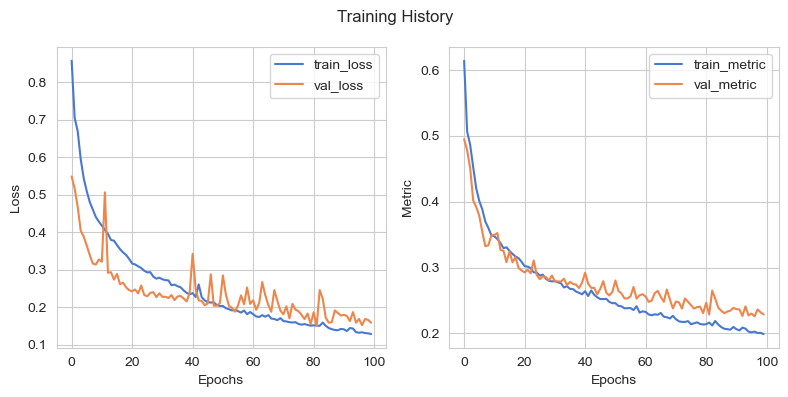

Number of epochs:  100
Training time:     28.7043s
Training loss:     0.1279
Training metric:   0.1991
Validation loss:   0.1581
Validation metric: 0.2289
Loss on test set:  0.1467425674200058


In [12]:
from gas_data_prediction.utils import train
# train the model
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=num_epochs,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()
print("Loss on test set: ", MODEL.evaluate((X_test, Y_test),mode="numpy",device=device))


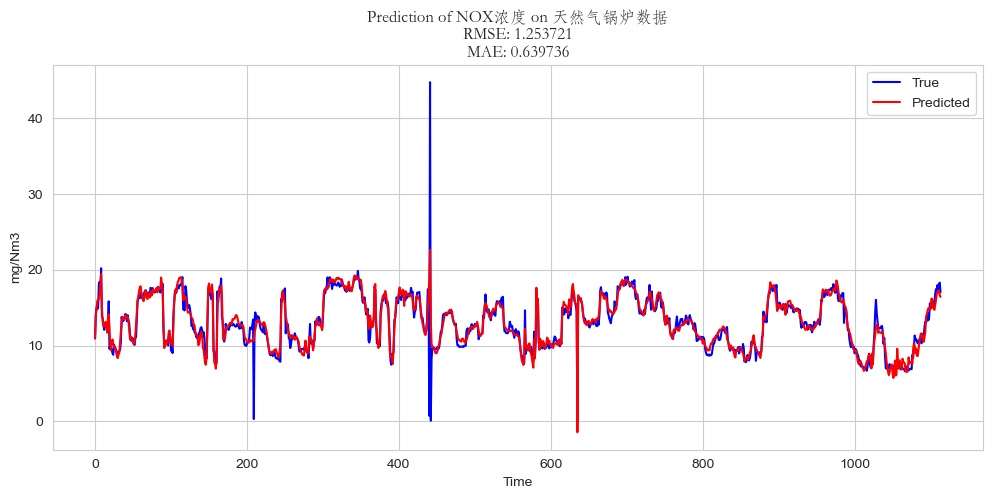

In [13]:
# Visualize on a particular variable and particular file
from gas_data_prediction.utils import visualize_var, get_pred_true_pairs, get_pred_true_pairs_with_Tensor

var_idx=1
data_idx=0

Y_pred, Y_true=get_pred_true_pairs_with_Tensor(MODEL,X_grouped[data_idx],Y_grouped[data_idx])

shared_params={
    'Y_pred': Y_pred,
    'Y_true': Y_true,
    'var_idx': var_idx,
    'var_names': output_var_names,
    'var_units': output_var_units,
    'data_name': "天然气锅炉数据",
    'var_mean': output_var_mean,
    'var_std_dev': output_var_std_dev,
}


visualize_var(**shared_params, plot_residual=0, rescale=1)

In [ ]:
def get_prediction_info(MODEL,X_test_grouped,Y_test_grouped,output_var_dict,output_var_mean,output_var_std_dev,data_idx):
    var_prediction_info={}
    for var_idx, (var_name, var_unit) in enumerate(output_var_dict.items()):
        Y_pred, Y_true=get_pred_true_pairs_with_Tensor(MODEL,X_test_grouped[data_idx],Y_test_grouped[data_idx])
        y_true=Y_true[:,var_idx] # shape: (n_output_vars,)
        y_pred=Y_pred[:,var_idx] # shape: (n_output_vars,)
        y_mean=output_var_mean[var_idx] # float
        y_std_dev=output_var_std_dev[var_idx] # float
        RMSE=np.sqrt(((y_true-y_pred)**2).mean())
        MAE=np.abs(y_true-y_pred).mean()
        RMSE_rescaled=RMSE*y_std_dev
        MAE_rescaled=MAE*y_std_dev
        var_prediction_info[var_name]=[var_unit, RMSE,RMSE_rescaled,MAE,MAE_rescaled]

    return pd.DataFrame(var_prediction_info,index=['unit', 'RMSE','RMSE_rescaled','MAE','MAE_rescaled']).T
    #df.to_csv('20241120_NN_prediction_info.csv')

df=get_prediction_info(MODEL,X_test_grouped,Y_test_grouped,output_var_dict,output_var_mean,output_var_std_dev,data_idx)
df

,unit,RMSE,RMSE_rescaled,MAE,MAE_rescaled
烟气含氧量（CEMS）,mg/Nm3,0.275599,0.309731,0.179107,0.201289
NOX浓度,mg/Nm3,0.43348,1.430102,0.200272,0.660722
烟气湿度（CEMS）,%,0.280208,0.226373,0.197239,0.159344
烟气压力（CEMS）,Pa,0.589332,3.825915,0.423169,2.747191
烟气温度（CEMS）,℃,0.183225,0.494906,0.136273,0.368084
一氧化碳,mg/Nm3,0.443283,6.372613,0.11405,1.639576
炉膛出口烟气压力,Pa,0.269112,0.202424,0.197561,0.148604
